### Clustering implementation
En esta sección se implementarán los métodos de clustering seleccionados previamente.
* `K-Means`
* `DBSCAN`
* `Gaussian Mixture Models (GMM)`
* `Hierarchical Clustering (Agglomerative)`

#### Scaling the data
Primero vamos a preparar los datos para utilizar los métodos de clustering.
Since different features may have different scales (e.g., `n_clicks` and `monto_compras`), it's important to scale the data so that all features are on a similar scale. This can be done using algún escalador from scikit-learn.

##### Escaladores y Transformadores: Descripción y Aplicabilidad

| Escalador           | Descripción                                                                                          | Aplicabilidad                                                                                     | No Aplicable                                                                                   |
|---------------------|------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------|
| **StandardScaler**  | Transforma las variables para que tengan media 0 y desviación estándar 1.                           | ✔ Útil para algoritmos sensibles a magnitudes (e.g., K-means, PCA, SVM).                        | ❌ Datos con distribuciones no normales o valores atípicos extremos.                           |
| **MinMaxScaler**    | Escala las variables al rango especificado (por defecto, entre 0 y 1).                              | ✔ Útil cuando las variables tienen rangos diferentes pero importa la proporcionalidad (e.g., clustering). | ❌ Datos con valores atípicos que distorsionen la escala.                                       |
| **MaxAbsScaler**    | Escala las variables en base al valor absoluto máximo de cada característica, manteniendo la dispersión. | ✔ Útil para datos con distribución dispersa pero no extrema (e.g., datos de entrada no negativos). | ❌ Datos con valores negativos o rangos muy diferentes.                                        |
| **RobustScaler**    | Escala usando la mediana y el rango intercuartil (IQR), resistente a valores atípicos.              | ✔ Adecuado para datos con valores extremos o distribuciones no normales.                        | ❌ Datos ya limpios o distribuidos normalmente.                                                |
| **Normalizer**      | Escala cada vector individual de muestra a una norma unitaria (e.g., norma L2).                     | ✔ Útil para datos dispersos o cuando las relaciones entre magnitudes no son relevantes (e.g., texto). | ❌ Características donde las magnitudes absolutas son importantes.                             |
| **PowerTransformer**| Aplica una transformación de potencia (Box-Cox o Yeo-Johnson) para hacer que los datos sean más gaussianos. | ✔ Adecuado para datos con distribuciones altamente sesgadas o asimétricas.                      | ❌ Datos ya normales o que no requieren ajuste en la simetría.                                 |
| **QuantileTransformer**| Transforma los datos en una distribución uniforme o normal según cuantiles.                      | ✔ Útil para normalizar distribuciones no gaussianas o muy asimétricas.                          | ❌ Datasets pequeños, ya que la transformación podría ser inconsistente.                       |
| **Binarizer**       | Convierte las características en valores binarios según un umbral.                                  | ✔ Útil para variables categóricas o datos booleanos.                                            | ❌ Características continuas que no necesitan ser dicotomizadas.                               |
| **FunctionTransformer**| Permite aplicar funciones personalizadas a las características.                                  | ✔ Útil para transformar datos con requisitos específicos no cubiertos por los escaladores estándar. | ❌ Transformaciones estándar que ya cubren las necesidades del dataset.                        |


| Variable            | StandardScaler | MinMaxScaler | MaxAbsScaler | RobustScaler | Normalizer | PowerTransformer | QuantileTransformer | Binarizer | FunctionTransformer |
|---------------------|----------------|--------------|--------------|--------------|------------|------------------|---------------------|-----------|---------------------|
| `n_clicks`          | 🟢 - Aceptable para normalizar la dispersión y poner los datos en una escala similar, útil para K-means. | 🟡 - Útil para ajustar valores a un rango [0, 1], pero puede perder la relación con la dispersión de datos. | 🟡 - Aceptable, pero no es ideal para columnas con alta dispersión y outliers. | 🟡 - Funciona en presencia de valores atípicos, aunque no es la mejor opción para una distribución sesgada. | 🔴 - No aplicable porque la magnitud y dispersión de los valores son importantes para el análisis de comportamiento. | 🟡 - Aceptable si se desea normalizar los datos en presencia de distribuciones sesgadas, pero no es ideal. | 🟡 - Útil si se requiere corregir la distribución sesgada, pero puede distorsionar la información. | 🔴 - No es adecuado, ya que se trata de una variable continua que debe mantener su escala. | 🟡 - Puede ser útil si se requiere aplicar una transformación específica o ajustar los valores. |
| `n_visitas`         | 🟢 - Aceptable para normalizar la dispersión y mantener la escala, útil para técnicas como K-means. | 🟡 - Útil para ajustar el rango a [0, 1], pero puede perder la relación de dispersión importante para el comportamiento. | 🟡 - Aceptable, pero no es ideal en presencia de valores atípicos y alta dispersión. | 🟡 - Funciona bien para columnas con valores atípicos, aunque no es la mejor opción si hay asimetría significativa. | 🔴 - No aplicable, ya que la dispersión general de los valores es importante para el análisis. | 🟡 - Adecuado para reducir sesgos, pero puede no ser tan efectivo en una distribución asimétrica. | 🟡 - Puede ser útil para hacer la distribución más uniforme, pero debe analizarse con cuidado. | 🔴 - No es aplicable, pues no se ajusta bien a una variable continua con magnitudes relevantes. | 🟡 - Puede ser útil si se requiere ajustar o transformar los valores para un análisis más específico. |
| `monto_compras`     | 🟡 - Moderadamente adecuado, ya que la distribución no es uniforme. La estandarización puede ser útil para hacer que los valores atípicos no influyan demasiado. | 🟡 - Útil para ajustar los valores a un rango definido, pero puede no ser adecuado si los valores varían mucho. | 🟡 - Aceptable, pero puede no ser la mejor opción si hay grandes dispersión o valores atípicos. | 🟢 - Ideal para manejar outliers y sesgos en distribuciones no simétricas. Es especialmente útil cuando se tienen grandes diferencias entre los clientes. | 🟡 - Puede no ser ideal debido a la dispersión y los valores atípicos, pero aún es posible usarla para una transformación. | 🟢 - Adecuado para reducir asimetría en los datos, haciéndolos más regulares y centrados. | 🟡 - Puede ser útil para normalizar la distribución, pero debe considerarse la naturaleza de la columna. | 🟡 - Aceptable si se requiere un ajuste de rango, pero no necesariamente mejora la variable. | 🟡 - Aceptable si se desea realizar una transformación que ajuste los valores, pero no es la mejor opción. |
| `monto_descuentos`  | 🟡 - Moderadamente adecuado, debido a la dispersión y valores atípicos. Puede ayudar a reducir la influencia de los outliers. | 🟡 - Útil para ajustar el rango de descuentos a un valor más manejable, pero puede perder contexto sobre la distribución. | 🟡 - Aceptable en general, aunque no ideal debido a la alta dispersión. | 🟢 - Ideal para tratar con valores atípicos y distribuciones sesgadas, como en el caso de los descuentos. | 🟡 - No es ideal debido a la naturaleza de los valores, pero aún puede servir en algunos contextos. | 🟢 - Adecuado para reducir la asimetría y hacer la distribución más regular. | 🟡 - Puede ser útil para transformar la distribución, pero debe evaluarse con cuidado si se ajusta al comportamiento de los descuentos. | 🟡 - No es ideal para esta variable, pues no mejora la capacidad de análisis. | 🟡 - Aceptable si se requiere una transformación ajustada específicamente a este caso. |
| `dias_primera_compra` | 🟢 - Adecuado para normalizar la dispersión de los datos, que están dentro de un rango relativamente definido. | 🟡 - Útil para ajustar el rango a [0, 1], pero no es necesario dado que la distribución es simétrica. | 🟡 - Aceptable si se busca una forma normalizada, pero no aporta mucho valor. | 🟢 - Útil para mitigar los efectos de los valores atípicos, aunque los datos no muestran un alto nivel de outliers. | 🟡 - No es necesario, ya que los datos son bastante simétricos. | 🟡 - Aceptable si se busca ajustar la asimetría, aunque no es necesario debido a la distribución normal. | 🟡 - Útil si se requiere ajustar la distribución, pero no es un cambio significativo. | 🔴 - No aplicable, pues la transformación binaria no es útil en esta variable continua. | 🟡 - Puede ser útil si se requiere realizar alguna transformación específica para un análisis concreto. |
| `info_perfil`       | 🟢 - Adecuado para normalizar la dispersión y hacer que todos los valores estén en la misma escala. | 🟡 - Útil para ajustar el rango de los valores a [0, 1], pero no siempre es necesario en el contexto de una variable ordinal. | 🟡 - Aceptable en presencia de dispersión, pero no ideal para variables ordinales. | 🟡 - Funciona en general, pero no es la mejor opción para una variable con relación de orden. | 🟡 - No es ideal para variables ordinales, ya que la normalización no tiene sentido en este caso. | 🟢 - Adecuado para manejar asimetría en la distribución. | 🟡 - Puede ser útil para transformar la distribución, pero no mejora mucho la interpretación. | 🔴 - No es aplicable, ya que no se ajusta bien a una variable ordinal. | 🟡 - Puede ser útil si se requiere ajuste específico, pero no es la mejor opción para una variable ordinal. |

##### Justificación del Método de Escalación

* `n_clicks`: StandardScaler. La distribución de `n_clicks` es sesgada a la derecha, con una alta dispersión y valores atípicos. El uso de StandardScaler es adecuado para normalizar los datos y mantener las características relevantes para técnicas como K-means.
* `n_visitas`: StandardScaler. Similar a `n_clicks`, esta variable tiene una distribución sesgada y dispersa. El uso de StandardScaler es apropiado para ajustar la distribución a una escala más uniforme y facilitar el análisis sin perder información importante.
* `monto_compras`: RobustScaler. Debido a la presencia de dos grupos de clientes con grandes diferencias en su gasto, y a la dispersión considerable de la variable, RobustScaler es el mejor método, ya que es menos sensible a los valores atípicos y mantiene las relaciones dentro de los grupos.
* `monto_descuentos`: RobustScaler. Al igual que `monto_compras`, esta variable tiene valores atípicos y una distribución sesgada. El uso de RobustScaler es adecuado porque maneja bien los valores extremos sin distorsionar la información de los descuentos.
* `dias_primera_compra`: StandardScaler. La distribución de `dias_primera_compra` es simétrica y no presenta una gran variabilidad, por lo que el uso de StandardScaler es adecuado para centrar y escalar los datos sin introducir sesgos innecesarios.
* `info_perfil`: StandardScaler. Al ser una variable ordinal con una distribución simétrica, StandardScaler es adecuado para normalizar la variable, asegurando que su influencia en el análisis sea proporcional sin perder la relación entre los valores.


In [236]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [237]:
# Loading cleaned dataset
dataset_path = "../data/processed/cleaned_dataset.csv"
df = pd.read_csv(dataset_path)
df = df.drop(columns=["ID","dias_primera_compra", "n_clicks", "info_perfil"])

In [238]:
# Util functions
def scale_minmax(df, column):
    scaler = MinMaxScaler()
    df[column] = scaler.fit_transform(df[[column]])

def plot_dendrogram(df_scaled, method):
    linked_sample = linkage(df_scaled, method)
    plt.figure(figsize=(10, 7))
    dendrogram(linked_sample, truncate_mode="level", p=5)
    plt.title('Dendrogram for Sample of 26000 Records')
    plt.xlabel('Data Points')
    plt.ylabel('Distance')
    plt.show()

def visualize_clusters(df_scaled, df_objective, column):
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(df_scaled)
    plt.figure(figsize=(6, 4))
    plt.scatter(principal_components[:, 0], principal_components[:, 1], c=df_objective[column], cmap='viridis', s=1)
    plt.title('Cluster Visualization (PCA)')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(label='Cluster')
    plt.show

def evaluate_clusters(df_scaled, df_objective, column):
    print(f"Silhouette = {silhouette_score(df_scaled, df_objective[column]):.4f}\n"
          f"Davies-Bouldin = {davies_bouldin_score(df_scaled, df_objective[column]):.4f}")
    visualize_clusters(df_scaled, df_objective, column)

In [239]:
# Scaling variables
df_scaled = df.copy()
minmax = list(df.columns)
for i in minmax:
    scale_minmax(df_scaled, i)

#### K_Means
Vamos a comenzar con la implementación de k_means.

##### Determining the number of clusters (K)
Once the data is scaled, we need to determine how many clusters we want to use. The optimal number of clusters can be determined using the **Elbow Method** or **Silhouette Score**.

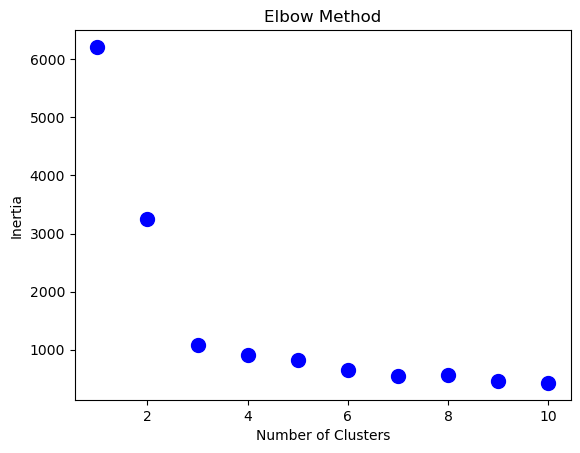

In [240]:
# Elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k).fit(df_scaled.values)
    inertia.append(kmeans.inertia_)

plt.scatter(range(1, 11), inertia, marker="o", s=100, color="blue")
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

##### Silhouette score

Con el siguiente código:

```python
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k).fit(df_scaled.values)
    score = silhouette_score(df_scaled, kmeans.labels_)
    print(f'K = {k}, Silhouette Score = {score}')
```

Se obtuvo la siguiente salida:
```python
K = 2,  Silhouette Score = 0.49008870050951725
K = 3,  Silhouette Score = 0.6382211139494461
K = 4,  Silhouette Score = 0.5520505385997547
K = 5,  Silhouette Score = 0.45557663314555197
K = 6,  Silhouette Score = 0.37186358841203254
K = 7,  Silhouette Score = 0.37952706713582285
K = 8,  Silhouette Score = 0.3694907693066217
K = 9,  Silhouette Score = 0.3641898126623838
K = 10, Silhouette Score = 0.34303524380374645
```

It has been decided to use K-Means with 3 clusters, based on the results obtained from the **Elbow Method** and the **Silhouette Score** analysis, which indicated that 3 clusters provide an appropriate segmentation with good separation between the groups.

In [241]:
df_kmeans = df.copy()
kmeans = KMeans(n_clusters=3).fit(df_scaled.values)
df_kmeans["cluster"] = kmeans.labels_

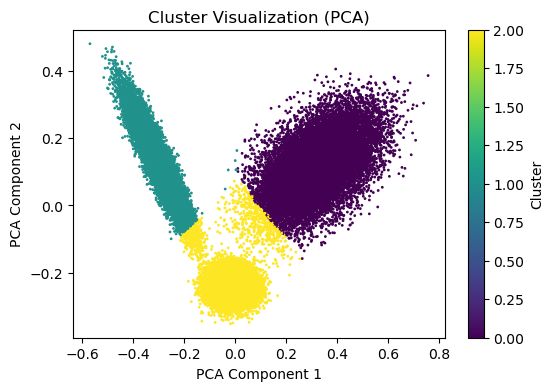

In [242]:
# Visualizing clusters
visualize_clusters(df_scaled, df_kmeans, "cluster")

#### DBScan
Ahora, seguiremos con la implementación de DBScan. DBScan es sensible a la distancia y, por lo tanto, es importante configurar correctamente los parámetros eps y min_samples.
Debido al tamaño de los datos (55000) se optará por usar el valor 6 en min_samples.
El valor eps se determinará de manera empírica.

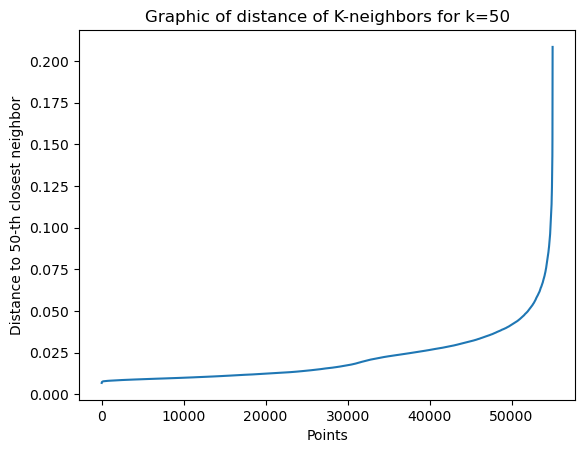

In [243]:
# Determining value of eps

k = 50
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(df_scaled)
distances, indices = neighbors_fit.kneighbors(df_scaled)
distances = np.sort(distances[:, k-1], axis=0)
plt.plot(distances)
plt.title(f'Graphic of distance of K-neighbors for k={k}')
plt.xlabel('Points')
plt.ylabel(f'Distance to {k}-th closest neighbor')
plt.show()

In [244]:
df_dbscan = df.copy()
eps = 0.040
min_samples = 50
dbscan = DBSCAN(eps = eps, min_samples = min_samples)
df_dbscan['cluster'] = dbscan.fit_predict(df_scaled)

In [245]:
# Not cleaned DBSCAN
print("Not cleaned DBSCAN")
print(f"eps={eps}, samples={min_samples}")
print(df_dbscan['cluster'].value_counts())

Not cleaned DBSCAN
eps=0.04, samples=50
cluster
 1    18331
 0    18274
 2    15703
-1     2698
Name: count, dtype: int64


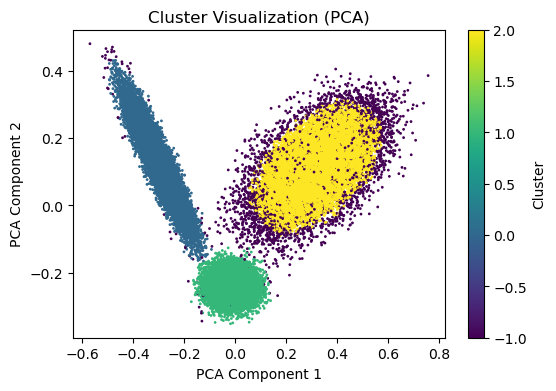

In [246]:
# Visualizing not cleaned clusters
visualize_clusters(df_scaled, df_dbscan, "cluster")

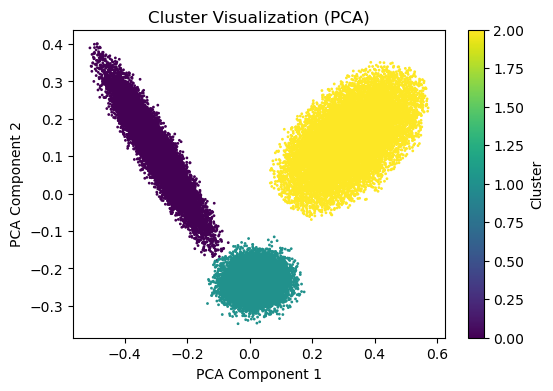

In [247]:
# Cleaning DBSCAN & Visualizing clusters
scaled_db = df_scaled[df_dbscan["cluster"] != -1]
df_dbscan = df_dbscan[df_dbscan["cluster"] != -1]
visualize_clusters(scaled_db, df_dbscan, "cluster")

#### Gaussian Mixture Models (GMM)

In [248]:
df_gaussian = df.copy()
n_clusters = 3
gmm = GaussianMixture(n_components=n_clusters)
df_gaussian["cluster"] = gmm.fit_predict(df_scaled)

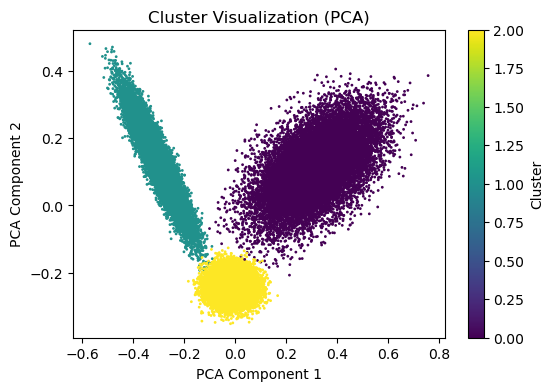

In [249]:
# Visualizing clusters
visualize_clusters(df_scaled, df_gaussian, "cluster")

#### Hierarchical Clustering (Agglomerative)

In [250]:
sample_size = 26000
hierarchical_subset = df.sample(n=sample_size)
scaled_subset = hierarchical_subset.copy()
for i in minmax:
    scale_minmax(scaled_subset, i)

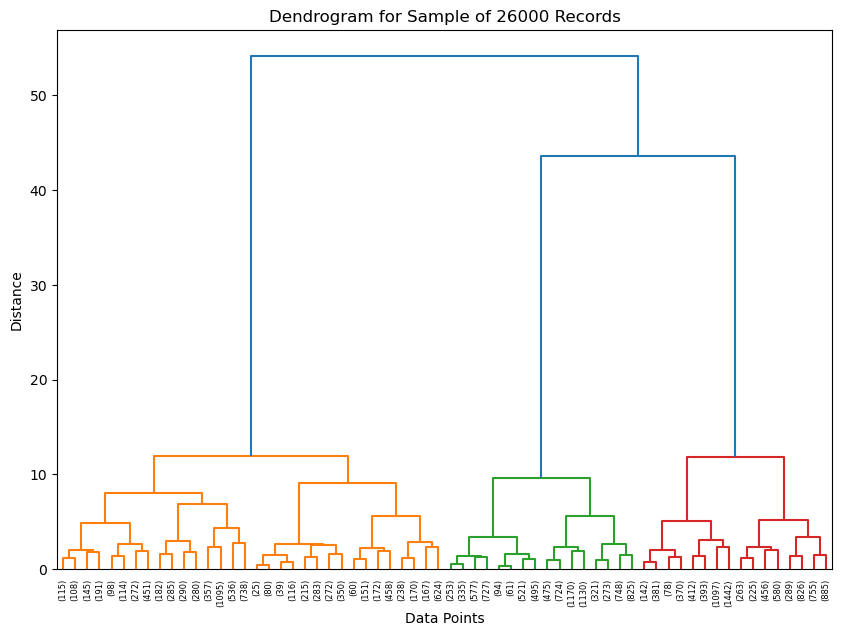

In [251]:
plot_dendrogram(df_scaled=scaled_subset, method="ward")

In [252]:
n_clusters = 3
agglomerative = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
hierarchical_subset["cluster"] = agglomerative.fit_predict(scaled_subset)

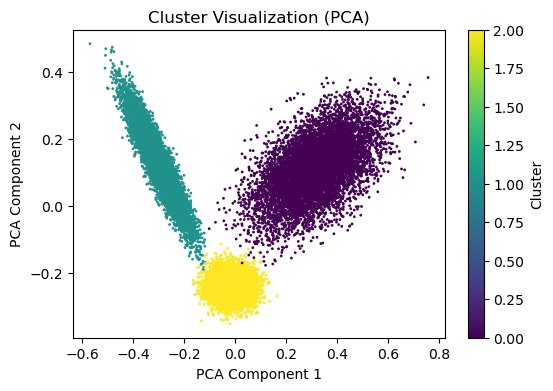

In [ ]:
# Visualizing clusters
visualize_clusters(scaled_subset, hierarchical_subset, "cluster")

#### Evaluating Clusters
Las métricas utilizadas para evaluar la calidad de los clusters son:
* Silhouette Score
* David Bouldin Score

Silhouette = 0.6382
Davies-Bouldin = 0.5010


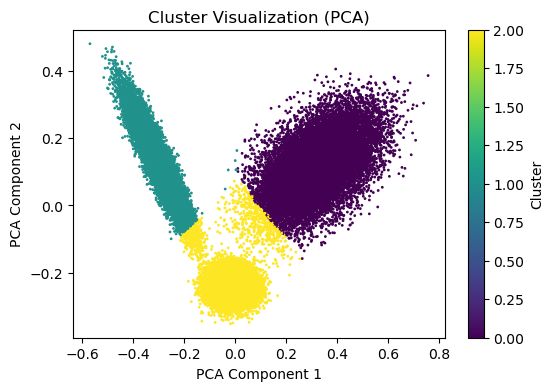

In [254]:
# Evaluating K-Means
evaluate_clusters(df_scaled, df_kmeans, "cluster")

Silhouette = 0.6605
Davies-Bouldin = 0.4660


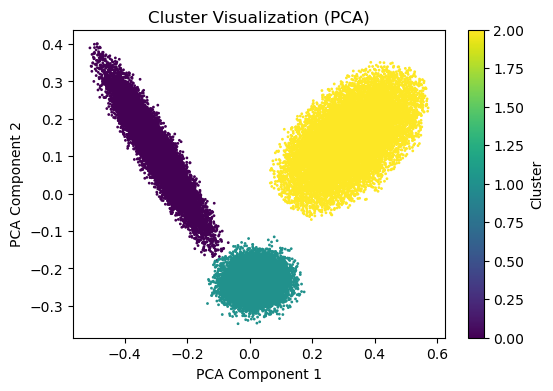

In [255]:
# Evaluating DBSCAN
evaluate_clusters(scaled_db, df_dbscan, "cluster")

Estos clusters tuvieron resultados óptimos, por lo que serán considerados para la siguiente etapa, el análisis de los mismos.

Silhouette = 0.6328
Davies-Bouldin = 0.5062


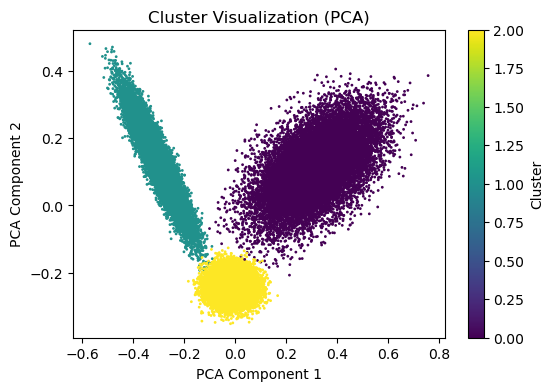

In [256]:
# Evaluating Gaussian Mixture
evaluate_clusters(df_scaled, df_gaussian, "cluster")

Silhouette = 0.6334
Davies-Bouldin = 0.5056


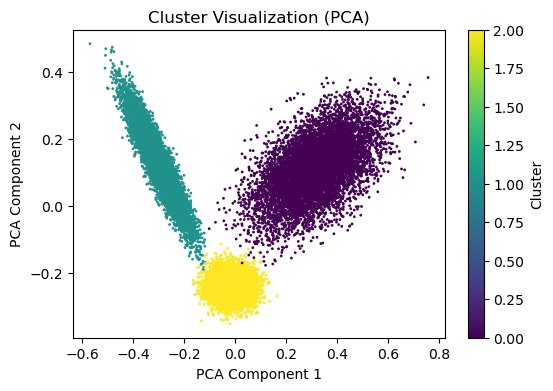

In [257]:
# Evaluating Hierarchical Clustering
evaluate_clusters(scaled_subset, hierarchical_subset, "cluster")